<a href="https://colab.research.google.com/github/galievaz/bike-sharing-project/blob/main/project-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

  Using cached setuptools-62.1.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.5.0
    Uninstalling setuptools-59.5.0:
      Successfully uninstalled setuptools-59.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
pytorch-lightning 1.5.10 requires setuptools==59.5.0, but you have setuptools 62.1.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 KB 30.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 62.1.0
    Uninstalling setuptools-62.1.0:
      Successfully uninstalled setuptools-62.1.0
ERROR: pip's dependency resolver does not currentl

In [28]:
!pip install kaggle

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
from autogluon.tabular import TabularPredictor
# Visualisation Libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Styling Preferences
%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

c:\Users\128524\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
c:\Users\128524\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-

# Loading data

In [2]:
test = pd.read_csv('../input/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('../input/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../input/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('../input/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('../input/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [4]:
# Create the train dataset in pandas by reading all data and joining csvs together to one
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int32         
 2   shop_id             int32         
 3   item_id             int32         
 4   item_price          float32       
 5   item_cnt_day        int32         
 6   item_name           object        
 7   item_category_id    int32         
 8   shop_name           object        
 9   item_category_name  object        
dtypes: datetime64[ns](1), float32(1), int32(5), object(3)
memory usage: 156.8+ MB


In [6]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast_dtypes(train)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int16         
 2   shop_id             int16         
 3   item_id             int16         
 4   item_price          float32       
 5   item_cnt_day        int16         
 6   item_name           object        
 7   item_category_id    int16         
 8   shop_name           object        
 9   item_category_name  object        
dtypes: datetime64[ns](1), float32(1), int16(5), object(3)
memory usage: 128.8+ MB
None


In [7]:
# Create the train dataset in pandas by reading the csv
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


In [8]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'shop_name',
       'item_category_name'],
      dtype='object')

In [9]:
# Set the parsing of the datetime column so we can use some of the `dt` features in pandas later
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [10]:
train.dtypes

date                  datetime64[ns]
date_block_num                 int16
shop_id                        int16
item_id                        int16
item_price                   float32
item_cnt_day                   int16
item_name                     object
item_category_id               int16
shop_name                     object
item_category_name            object
dtype: object

In [11]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


In [12]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.00,14.57,9.42,0.00,7.00,14.00,23.00,33.00
shop_id,2935849.00,33.00,16.23,0.00,22.00,31.00,47.00,59.00
item_id,2935849.00,10197.23,6324.30,0.00,4476.00,9343.00,15684.00,22169.00
item_price,2935849.00,890.62,1726.44,-1.00,249.00,399.00,999.00,307980.00
item_cnt_day,2935849.00,1.24,2.62,-22.00,1.00,1.00,1.00,2169.00
item_category_id,2935849.00,40.00,17.10,0.00,28.00,40.00,55.00,83.00


In [13]:
# Create the test pandas dataframe in pandas by reading the csv
test = pd.read_csv('../input/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [14]:
# Same thing as train and test dataset
submission = pd.read_csv('../input/sample_submission.csv')
submission.head()

,ID,item_cnt_month
0,0,0.50
1,1,0.50
2,2,0.50
3,3,0.50
4,4,0.50


In [15]:
submission.describe()

,ID,item_cnt_month
count,214200.00,214200.00
mean,107099.50,0.50
std,61834.36,0.00
min,0.00,0.50
25%,53549.75,0.50
50%,107099.50,0.50
75%,160649.25,0.50
max,214199.00,0.50


In [16]:
print("----------Top-5- Record----------")
print(train.head(5))


print("----------Shape of Data----------")
print("Number of rows = {}, Number of columns = {}".format(len(train), len(train.columns)))


----------Top-5- Record----------
        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-02-01               0       59    22154      999.00             1   
1 2013-03-01               0       25     2552      899.00             1   
2 2013-05-01               0       25     2552      899.00            -1   
3 2013-06-01               0       25     2554     1709.05             1   
4 2013-01-15               0       25     2555     1099.00             1   

                                  item_name  item_category_id  \
0                         ЯВЛЕНИЕ 2012 (BD)                37   
1  DEEP PURPLE  The House Of Blue Light  LP                58   
2  DEEP PURPLE  The House Of Blue Light  LP                58   
3  DEEP PURPLE  Who Do You Think We Are  LP                58   
4   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56   

                shop_name                   item_category_name  
0  Ярославль ТЦ "Альтаир"                       Кино 

In [17]:
print("-----------Data Types-----------")
print(train.dtypes)

-----------Data Types-----------
date                  datetime64[ns]
date_block_num                 int16
shop_id                        int16
item_id                        int16
item_price                   float32
item_cnt_day                   int16
item_name                     object
item_category_id               int16
shop_name                     object
item_category_name            object
dtype: object


In [18]:
print("----------Missing value-----------")
print(train.isnull().sum())
print("----------Null value-----------")
print(train.isna().sum())

----------Missing value-----------
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
shop_name             0
item_category_name    0
dtype: int64
----------Null value-----------
date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
shop_name             0
item_category_name    0
dtype: int64


In [19]:
sales_by_item_id = train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

As the curve of sales by item id is decreasing, there are a lot of old products in train data so means that it depends on season and time.

<AxesSubplot:>

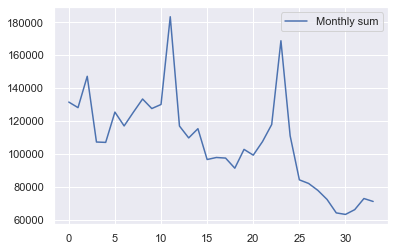

In [20]:
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

<AxesSubplot:>

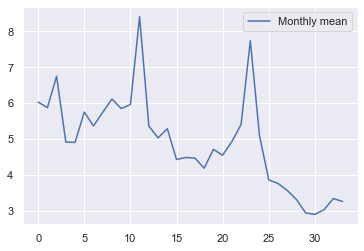

In [21]:
sales_by_item_id.mean()[1:].plot(legend=True, label="Monthly mean")

In [22]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-09-10,33,25,7460,299.00,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.00,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.00,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3


In [23]:
# Extract time based features.
train['year'] = train['date_block_num'].apply(lambda x: ((x//12) + 2013))
train['month'] = train['date_block_num'].apply(lambda x: (x % 12))
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,2013,0
1,2013-03-01,0,25,2552,899.00,1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,2013,0
2,2013-05-01,0,25,2552,899.00,-1,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,2013,0
3,2013-06-01,0,25,2554,1709.05,1,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,2013,0
4,2013-01-15,0,25,2555,1099.00,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,2013,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2015,9
2935845,2015-09-10,33,25,7460,299.00,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2015,9
2935846,2015-10-14,33,25,7459,349.00,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2015,9
2935847,2015-10-22,33,25,7440,299.00,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3,2015,9


How many products are outdated? (no sales for the last 6 months)

In [24]:
outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))

Outdated items: 12391


How many outdated items in test data?

In [25]:
test = pd.read_csv('../input/test.csv')
print('Outdated items in test set:', len(test[test['item_id'].isin(outdated_items['item_id'])]))

Outdated items in test set: 6888


As well as data leakage is a one of important things in EDA part, let's check for the same item id and shop id rows in both sets: train and test data.

In [26]:
# Data leakage
# Check with test data for considering and leaving only rows with the same shop_id's and item_id's
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

# Only shops that exist in test set.
correlate_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
correlate_train = correlate_train[correlate_train['item_id'].isin(test_item_ids)]

print('Initial data set size :', train.shape[0])
#print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Data set size after data leakage between correlated train and initial train:', correlate_train.shape[0],'/',(train.shape[0]) )

Initial data set size : 2935849
Data set size after data leakage between correlated train and initial train: 1224439 / 2935849


In [27]:
# Reduce train set to just match ones in test set regarding train_id and shop_id
train = correlate_train
len(train)

1224439

Such a less number of duplicate probably don;t make invive to model prediction, so just leave as well

In [28]:
# Find duplicates
print('Number of duplicates:', len(train[train.duplicated()]))

train[train.duplicated()]

Number of duplicates: 5


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month
1435367,2014-02-23,13,50,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",Игры - XBOX 360,2014,1
1496766,2014-03-23,14,21,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Москва МТРЦ ""Афи Молл""",Игры - XBOX 360,2014,2
1671873,2014-01-05,16,50,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",Игры - XBOX 360,2014,4
1866340,2014-12-07,18,25,3423,999.00,1,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Москва ТРК ""Атриум""",Игры - XBOX 360,2014,6
2198566,2014-12-31,23,42,21619,499.00,1,ЧЕЛОВЕК ДОЖДЯ (BD),37,"СПб ТК ""Невский Центр""",Кино - Blu-Ray,2014,11


<AxesSubplot:xlabel='item_price'>

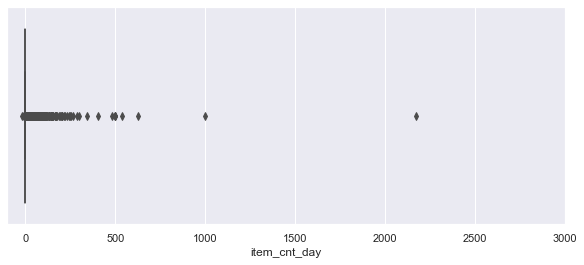

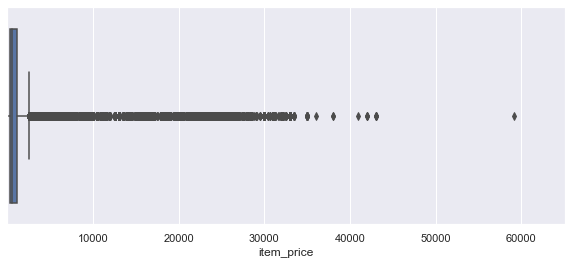

In [29]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [30]:
train.loc[train.item_cnt_day>2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month
2909818,2015-10-28,33,12,11373,0.91,2169,Доставка до пункта выдачи (Boxberry),9,Интернет-магазин ЧС,Доставка товара,2015,9


In [31]:
# Look at the most expensive item name
train.loc[train.item_price>50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month
885138,2013-09-17,8,12,11365,59200.00,1,Доставка (EMS),9,Интернет-магазин ЧС,Доставка товара,2013,8


In [32]:
train = train[train.item_price<50000]
train = train[train.item_cnt_day<1000]

In [33]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,2013,0
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2013,0
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2013,0
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2013,0
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2013,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2015,9
2935845,2015-09-10,33,25,7460,299.00,1,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2015,9
2935846,2015-10-14,33,25,7459,349.00,1,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,2015,9
2935847,2015-10-22,33,25,7440,299.00,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3,2015,9


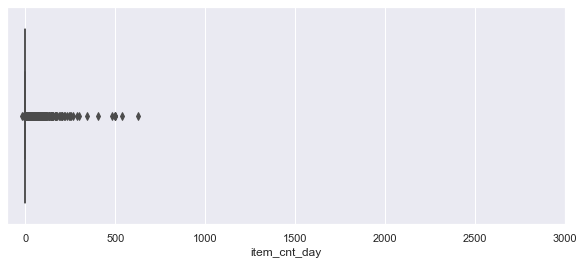

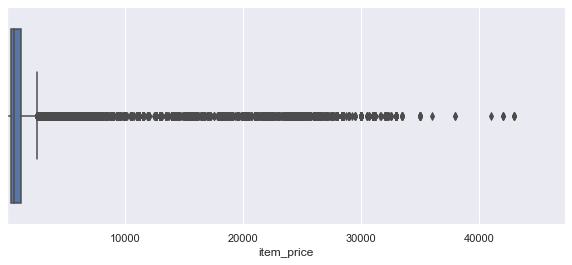

In [34]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

plt.show()

In [35]:
#Check for rows where item_price < 0
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month


In [36]:
train['shop_name'].unique()

array(['Ярославль ТЦ "Альтаир"', 'Москва ТРК "Атриум"',
       'Москва ТК "Буденовский" (пав.К7)', 'Курск ТЦ "Пушкинский"',
       'Москва Магазин С21', 'Красноярск ТЦ "Июнь"',
       'Москва МТРЦ "Афи Молл"', 'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Ареал" (Беляево)', 'Волжский ТЦ "Волга Молл"',
       'Воронеж (Плехановская, 13)', 'Адыгея ТЦ "Мега"',
       'Балашиха ТРК "Октябрь-Киномир"', 'Воронеж ТРЦ "Максимир"',
       'Коломна ТЦ "Рио"', 'Калуга ТРЦ "XXI век"',
       'Жуковский ул. Чкалова 39м?', 'Казань ТЦ "ПаркХаус" II',
       'Интернет-магазин ЧС', 'Уфа ТЦ "Семья" 2',
       'Москва ТЦ "Семеновский"', 'Н.Новгород ТРЦ "Фантастика"',
       'Чехов ТРЦ "Карнавал"', 'Сургут ТРЦ "Сити Молл"',
       'Тюмень ТЦ "Гудвин"', 'СПб ТК "Невский Центр"',
       'Уфа ТК "Центральный"', 'РостовНаДону ТЦ "Мега"', 'Омск ТЦ "Мега"',
       'Самара ТЦ "Мелодия"', 'Новосибирск ТЦ "Мега"',
       'Сергиев Посад ТЦ "7Я"', 'Самара ТЦ "ПаркХаус"',
       'Вологда ТРЦ "Мармелад"', 'Яку

In [37]:
len(train.loc[train.item_cnt_day<0, 'item_cnt_day'])

2941

In [38]:
# Create a column for city
#train['city'] = train['shop_name'].str.split(' ').map(lambda x: x[0])
train['shop_name'] = train['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
train['shop_city'] = train['shop_name'].str.partition(' ')[0]
train['shop_type'] = train['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month,shop_city,shop_type
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,ярославль тц альтаир,Кино - Blu-Ray,2013,0,ярославль,тц
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк


In [39]:
train['shop_city'].unique()

array(['ярославль', 'москва', 'курск', 'красноярск', 'волжский',
       'воронеж', 'адыгея', 'балашиха', 'коломна', 'калуга', 'жуковский',
       'казань', 'интернетмагазин', 'уфа', 'нновгород', 'чехов', 'сургут',
       'тюмень', 'спб', 'ростовнадону', 'омск', 'самара', 'новосибирск',
       'сергиев', 'вологда', 'якутск', 'цифровой', 'томск'], dtype=object)

In [40]:
train['shop_type'].unique()

array(['тц', 'трк', 'тк', 'NO_DATA', 'мтрц', 'трц'], dtype=object)

In [41]:
from sklearn.preprocessing import LabelEncoder
# Encode the city name into a code column
train['shop_city_code'] = LabelEncoder().fit_transform(train['shop_city'])
train['shop_type_code'] = LabelEncoder().fit_transform(train['shop_type'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month,shop_city,shop_type,shop_city_code,shop_type_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,ярославль тц альтаир,Кино - Blu-Ray,2013,0,ярославль,тц,27,5
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3


In [42]:
sales_by_shop_id = train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

for i in range(6,28):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())


Not exists in month 6 [34 36 39 48 49]
Not exists in month 7 [34 36 39 48 49]
Not exists in month 8 [34 36 39 48 49]
Not exists in month 9 [34 36 39 48 49]
Not exists in month 10 [34 36 39 48 49]
Not exists in month 11 [34 36 39 48]
Not exists in month 12 [34 36 39 48]
Not exists in month 13 [34 36 39 48]
Not exists in month 14 [34 36 48]
Not exists in month 15 [34 36]
Not exists in month 16 [34 36]
Not exists in month 17 [34 36]
Not exists in month 18 [36]
Not exists in month 19 [36]
Not exists in month 20 [36]
Not exists in month 21 [36]
Not exists in month 22 [36]
Not exists in month 23 [36]
Not exists in month 24 [36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]
Not exists in month 32 [36]
Not exists in month 33 []
Shop is outdated for month 6 []
Shop is outdated for month 7 []
Shop is outdated for month 8 []
Shop is outdated for mon

In [43]:
# Create separate column with split category name
train['split_category_name'] = train['item_category_name'].str.split(' - ')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month,shop_city,shop_type,shop_city_code,shop_type_code,split_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,ярославль тц альтаир,Кино - Blu-Ray,2013,0,ярославль,тц,27,5,"[Кино, Blu-Ray]"
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3,"[Музыка, CD локального производства]"
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3,"[Музыка, CD локального производства]"
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3,"[Музыка, CD локального производства]"
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3,"[Музыка, CD локального производства]"


In [44]:
train['split_category_name'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Музыка, CD локального производства]         173049
[Игры PC, Стандартные издания]               162909
[Кино, DVD]                                  138320
[Игры, PS3]                                   86795
[Игры, XBOX 360]                              78038
[Игры, PS4]                                   60101
[Кино, Blu-Ray]                               52356
[Игры PC, Дополнительные издания]             43354
[Подарки, Настольные игры (компактные)]       29301
[Подарки, Мягкие игрушки]                     27242
[Подарки, Сумки, Альбомы, Коврики д/мыши]     26487
[Подарки, Фигурки]                            24879
[Подарки, Настольные игры]                    24454
[Программы, Для дома и офиса]                 21534
[Карты оплаты, PSN]                           19462
[Кино, Blu-Ray 3D]                            17914
[Подарки, Развитие]                           16652
[Аксессуары, PS4]                             16448
[Подарки, Сувениры (в навеску)]               16085
[Книги, Мето

In [45]:
# Make column for category type and encode
train['item_category_type'] = train['split_category_name'].map(lambda x : x[0].strip())
train['item_category_type_code'] = LabelEncoder().fit_transform(train['item_category_type'])

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,year,month,shop_city,shop_type,shop_city_code,shop_type_code,split_category_name,item_category_type,item_category_type_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,ярославль тц альтаир,Кино - Blu-Ray,2013,0,ярославль,тц,27,5,"[Кино, Blu-Ray]",Кино,7
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3,"[Музыка, CD локального производства]",Музыка,9
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3,"[Музыка, CD локального производства]",Музыка,9
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3,"[Музыка, CD локального производства]",Музыка,9
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,2013,0,москва,трк,12,3,"[Музыка, CD локального производства]",Музыка,9


In [46]:
# Do the same for subtype, make column wiht name if nan then set to the type
train['item_category_subtype'] = train['split_category_name'].map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)
# Make separate encoded column
train['item_category_subtype_code'] = LabelEncoder().fit_transform(train['item_category_subtype'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,...,month,shop_city,shop_type,shop_city_code,shop_type_code,split_category_name,item_category_type,item_category_type_code,item_category_subtype,item_category_subtype_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,ярославль тц альтаир,Кино - Blu-Ray,...,0,ярославль,тц,27,5,"[Кино, Blu-Ray]",Кино,7,Blu-Ray,1
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,...,0,москва,трк,12,3,"[Музыка, CD локального производства]",Музыка,9,CD локального производства,3
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,...,0,москва,трк,12,3,"[Музыка, CD локального производства]",Музыка,9,CD локального производства,3
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,...,0,москва,трк,12,3,"[Музыка, CD локального производства]",Музыка,9,CD локального производства,3
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,москва трк атриум,Музыка - CD локального производства,...,0,москва,трк,12,3,"[Музыка, CD локального производства]",Музыка,9,CD локального производства,3


In [47]:
train['item_category_subtype'].unique()

array(['Blu-Ray', 'CD локального производства', 'Стандартные издания',
       'Винил', 'XBOX 360', 'Методические материалы 1С',
       'Для дома и офиса', 'PSP', 'PS3', 'Развитие', '1С:Предприятие 8',
       'MP3', 'Подарочные издания', 'Дополнительные издания', 'PSVita',
       'PSN', 'CD фирменного производства', 'Blu-Ray 3D', 'Аудиокниги 1С',
       'Обучающие', 'DVD', 'Аудиокниги', 'Коллекционное', 'Сувениры',
       'Гаджеты, роботы, спорт', 'Служебные', 'Настольные игры',
       'Настольные игры (компактные)', 'Мягкие игрушки',
       'Элементы питания', 'Фигурки', 'Доставка товара',
       'Коллекционные издания', 'Сумки, Альбомы, Коврики д/мыши',
       'Атрибутика', 'Цифра', 'Для дома и офиса (Цифра)',
       'Обучающие (Цифра)', 'Сувениры (в навеску)', 'PS4',
       'Аудиокниги (Цифра)', 'Аксессуары для игр', 'Live!',
       'Live! (Цифра)', 'XBOX ONE', 'Комиксы, манга',
       'Артбуки, энциклопедии', 'Windows (Цифра)', 'MAC (Цифра)'],
      dtype=object)

In [48]:
train['item_category_type'].unique()

array(['Кино', 'Музыка', 'Игры PC', 'Игры', 'Книги', 'Программы',
       'Подарки', 'Аксессуары', 'Карты оплаты', 'Служебные',
       'Элементы питания', 'Доставка товара', 'Игровые консоли',
       'Игры Android'], dtype=object)

In [49]:
train = train.drop(['shop_name', 
                    'shop_city',
                    'shop_type',
                    'item_category_name', 
                    'split_category_name', 
                    'item_category_type', 
                    'item_category_subtype',
                   ], axis = 1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,month,shop_city_code,shop_type_code,item_category_type_code,item_category_subtype_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,2013,0,27,5,7,1
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,12,3,9,3
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,12,3,9,3
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,12,3,9,3
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,12,3,9,3


In [50]:
train=downcast_dtypes(train)

In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224436 entries, 0 to 2935848
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   date                        1224436 non-null  datetime64[ns]
 1   date_block_num              1224436 non-null  int16         
 2   shop_id                     1224436 non-null  int16         
 3   item_id                     1224436 non-null  int16         
 4   item_price                  1224436 non-null  float32       
 5   item_cnt_day                1224436 non-null  int16         
 6   item_name                   1224436 non-null  object        
 7   item_category_id            1224436 non-null  int16         
 8   year                        1224436 non-null  int16         
 9   month                       1224436 non-null  int16         
 10  shop_city_code              1224436 non-null  int16         
 11  shop_type_code          

In [52]:
print("Number of unique Item names = {}".format(len(train.item_name.unique())))

Number of unique Item names = 4716


Let's see the most used and common features in item names

In [53]:
from collections import Counter
from operator import itemgetter
items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')

result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature'])

print('Most common aditional features:', result)

Most common aditional features:            feature  count
130   документация    284
131     английская    340
132        русские    399
133       субтитры    400
134            360    465
135          jewel    552
136           xbox    589
137            ps3    611
138        русская   1428
139       цифровая   1995
140             pc   2585
141         версия   3427
1981           box    246
1983            3d    409
1985           dvd    503
1986      digipack    541
1988          фирм    757
1991           mp3    854
1992            cd    871
1993        регион   1849
1994            bd   2320


In [54]:
import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

train['item_name_token'] = train['item_name'].apply(lambda x: name_correction(x))

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,month,shop_city_code,shop_type_code,item_category_type_code,item_category_subtype_code,item_name_token
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,2013,0,27,5,7,1,явление 2012
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,12,3,9,3,del rey lana born to die the paradise edition 2cd
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,12,3,9,3,del rey lana born to die the paradise edition 2cd
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,12,3,9,3,del rey lana born to die the paradise edition 2cd
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,12,3,9,3,del rey lana born to die the paradise edition 2cd


In [55]:
train['item_platform']= pd.np.where(train.item_name_token.str.contains('pc'), 'pc',
                        pd.np.where(train.item_name_token.str.contains('ps3'), 'ps3',
                        pd.np.where(train.item_name_token.str.contains('xbox'), 'xbox',
                        '0')))
# Make separate encoded column
train['item_platform_code'] = LabelEncoder().fit_transform(train['item_platform'])


In [56]:
train['item_platform'].unique()

array(['0', 'xbox', 'ps3', 'pc'], dtype=object)

In [57]:
train['item_platform_code'].unique()

array([0, 3, 2, 1])

In [58]:
train['item_digital']= pd.np.where(train.item_name_token.str.contains('dvd'), 'dvd',
                        pd.np.where(train.item_name_token.str.contains('cd'), 'cd',
                        pd.np.where(train.item_name_token.str.contains('mp3'), 'mp3',
                        '0')))
# Make separate encoded column
train['item_digital_code'] = LabelEncoder().fit_transform(train['item_digital'])

In [59]:
train['item_digital'].unique()

array(['0', 'cd', 'dvd', 'mp3'], dtype=object)

In [60]:
train['item_digital_code'].unique()

array([0, 1, 2, 3])

In [61]:
train['item_lang']= pd.np.where(train.item_name_token.str.contains('англ'), 'англ',
                    pd.np.where(train.item_name_token.str.contains('русск'), 'русск', '0'))
# Make separate encoded column
train['item_lang_code'] = LabelEncoder().fit_transform(train['item_lang'])                   


In [62]:
train['item_lang_code'].unique()

array([0, 1, 2])

In [63]:
train['item_name'].value_counts()

Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм                                    26487
Playstation Store пополнение бумажника: Карта оплаты 1000 руб.                            7919
Прием денежных средств для 1С-Онлайн                                                      7896
Diablo III [PC, Jewel, русская версия]                                                    6337
Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box     5985
                                                                                         ...  
Сумка Adventure Time BMO Small Messenger Bag                                                 1
Футболка Skyrim Dragonborn XL                                                                1
СТАНЦИОННЫЙ СМОТРИТЕЛЬ (rem)                                                                 1
Комикс Темная башня Том 3 Предательство                                                      1
АХ, ВОДЕВИЛЬ, ВОДЕВИЛЬ (rem)                      

In [64]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,month,...,shop_type_code,item_category_type_code,item_category_subtype_code,item_name_token,item_platform,item_platform_code,item_digital,item_digital_code,item_lang,item_lang_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,2013,0,...,5,7,1,явление 2012,0,0,0,0,0,0
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1,V/A Nu Jazz Selection (digipack),55,2015,9,...,3,9,3,v a nu jazz selection,0,0,0,0,0,0
2935845,2015-09-10,33,25,7460,299.00,1,V/A The Golden Jazz Collection 1 2CD,55,2015,9,...,3,9,3,v a the golden jazz collection 1 2cd,0,0,cd,1,0,0
2935846,2015-10-14,33,25,7459,349.00,1,V/A The Best Of The 3 Tenors,55,2015,9,...,3,9,3,v a the best of the 3 tenors,0,0,0,0,0,0
2935847,2015-10-22,33,25,7440,299.00,1,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,2015,9,...,3,9,9,v a relax collection planet mp3,0,0,mp3,3,0,0


In [65]:
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,month,...,shop_type_code,item_category_type_code,item_category_subtype_code,item_name_token,item_platform,item_platform_code,item_digital,item_digital_code,item_lang,item_lang_code
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,2013,0,...,5,7,1,явление 2012,0,0,0,0,0,0
10,2013-03-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
11,2013-05-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
12,2013-07-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
13,2013-08-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
14,2013-10-01,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
15,2013-11-01,0,25,2574,399.00,2,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
16,2013-01-13,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
17,2013-01-16,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
18,2013-01-26,0,25,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,3,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0


In [66]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'year', 'month',
       'shop_city_code', 'shop_type_code', 'item_category_type_code',
       'item_category_subtype_code', 'item_name_token', 'item_platform',
       'item_platform_code', 'item_digital', 'item_digital_code', 'item_lang',
       'item_lang_code'],
      dtype='object')

In [67]:
# Group by month (date_block_num)
# Could do more complex, just want something very basic to aggregate
train_by_month = train.sort_values('date').groupby([
                                                    'date_block_num', 
                                                    'item_category_type_code',
                                                    'item_category_subtype_code',
                                                    'item_id',
                                                    'shop_city_code',
                                                    'shop_id', 
                                                    'item_category_id',
                                                    'year', 'month',
                                                    'item_platform_code', 'item_digital_code','item_lang_code'
    # Keep simple; will just use the above columns 
], as_index=False)
train_by_month.size()

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_city_code,shop_id,item_category_id,year,month,item_platform_code,item_digital_code,item_lang_code,size
0,0,0,10,5572,0,2,2,2013,0,0,0,0,7
1,0,0,10,5572,1,3,2,2013,0,0,0,0,3
2,0,0,10,5572,2,4,2,2013,0,0,0,0,3
3,0,0,10,5572,4,6,2,2013,0,0,0,0,7
4,0,0,10,5572,4,7,2,2013,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
600153,33,13,48,22092,21,48,83,2015,9,0,0,0,1
600154,33,13,48,22092,22,49,83,2015,9,0,0,0,1
600155,33,13,48,22092,23,52,83,2015,9,0,0,0,1
600156,33,13,48,22092,23,53,83,2015,9,0,0,0,1


In [68]:

# everything is organised by date block num, great!
train_by_month.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,year,month,...,shop_type_code,item_category_type_code,item_category_subtype_code,item_name_token,item_platform,item_platform_code,item_digital,item_digital_code,item_lang,item_lang_code
57242,2013-01-01,0,14,1905,249.00,1,"Bestseller. Grand Theft Auto: San Andreas [PC,...",30,2013,0,...,5,5,42,bestseller grand theft auto san andreas,0,0,0,0,0,0
108778,2013-01-01,0,46,16451,499.00,1,ОБЛАЧНЫЙ АТЛАС (BD),37,2013,0,...,5,7,1,облачный атлас,0,0,0,0,0,0
10116,2013-01-01,0,19,2808,999.00,2,"Diablo III [PC, Jewel, русская версия]",30,2013,0,...,5,5,42,diablo iii,0,0,0,0,0,0
10111,2013-01-01,0,19,2574,399.00,1,DEL REY LANA Born To Die The Paradise Editio...,55,2013,0,...,5,9,3,del rey lana born to die the paradise edition 2cd,0,0,cd,1,0,0
51977,2013-01-01,0,18,3686,899.00,1,"God of War 3 (Essentials) [PS3, русская версия]",19,2013,0,...,5,3,10,god of war 3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887817,2015-12-10,33,46,22102,1250.00,1,Энциклопедия Мир Ведьмака,42,2015,9,...,5,8,19,энциклопедия мир ведьмака,0,0,0,0,0,0
2887766,2015-12-10,33,46,20801,7499.00,1,Фигурка Star Wars Darth Vader Return of Anakin...,72,2015,9,...,5,10,46,фигурка star wars darth vader return of anakin...,0,0,0,0,0,0
2887761,2015-12-10,33,46,20629,2399.00,1,"Фигурка Mortal Kombat X Series 1 Scorpion 6""",72,2015,9,...,5,10,46,фигурка mortal kombat x series 1 scorpion 6,0,0,0,0,0,0
2897403,2015-12-10,33,56,5232,1199.00,1,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,2015,9,...,4,3,16,need for speed rivals,0,0,0,0,0,0


In [69]:
# Aggregate item price and item count
train_by_month = train_by_month.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [70]:
train_by_month.head()

date_block_num item_category_type_code item_category_subtype_code item_id  \
                                                                              
0              0                       0                         10    5572   
1              0                       0                         10    5572   
2              0                       0                         10    5572   
3              0                       0                         10    5572   
4              0                       0                         10    5572   

  shop_city_code shop_id item_category_id  year month item_platform_code  \
                                                                           
0              0       2                2  2013     0                  0   
1              1       3                2  2013     0                  0   
2              2       4                2  2013     0                  0   
3              4       6                2  2013     0                  0   
4              4       7                2  2013     0                  0   

  item_digital_code item_lang_code item_price         item_cnt_day             
                                          sum    mean          sum mean count  
0                 0              0   10730.00 1532.86            9 1.29     7  
1                 0              0    4770.00 1590.00            3 1.00     3  
2                 0              0    4570.00 1523.33            3 1.00     3  
3                 0              0   11130.00 1590.00            8 1.14     7  
4                 0              0   11030.00 1575.71            8 1.14     7

In [71]:
# Sanity check on number of months
train_by_month.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int64)

In [72]:
train_by_month.columns

MultiIndex([(            'date_block_num',      ''),
            (   'item_category_type_code',      ''),
            ('item_category_subtype_code',      ''),
            (                   'item_id',      ''),
            (            'shop_city_code',      ''),
            (                   'shop_id',      ''),
            (          'item_category_id',      ''),
            (                      'year',      ''),
            (                     'month',      ''),
            (        'item_platform_code',      ''),
            (         'item_digital_code',      ''),
            (            'item_lang_code',      ''),
            (                'item_price',   'sum'),
            (                'item_price',  'mean'),
            (              'item_cnt_day',   'sum'),
            (              'item_cnt_day',  'mean'),
            (              'item_cnt_day', 'count')],
           )

In [73]:
# Rename columns
train_by_month.columns = ['date_block_num', 
                         'item_category_type_code',
                         'item_category_subtype_code',
                         'item_id',
                         'shop_id',
                         'shop_city_code', 
                         'item_category_id',
                         'year', 
                         'month',
                         'item_platform',
                         'item_digital',
                         'item_lang',
                         'sum_item_price',
                         'mean_item_price',
                         'sum_item_count',
                         'mean_item_count',
                         'transactions']
train_by_month.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,item_digital,item_lang,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
0,0,0,10,5572,0,2,2,2013,0,0,0,0,10730.00,1532.86,9,1.29,7
1,0,0,10,5572,1,3,2,2013,0,0,0,0,4770.00,1590.00,3,1.00,3
2,0,0,10,5572,2,4,2,2013,0,0,0,0,4570.00,1523.33,3,1.00,3
3,0,0,10,5572,4,6,2,2013,0,0,0,0,11130.00,1590.00,8,1.14,7
4,0,0,10,5572,4,7,2,2013,0,0,0,0,11030.00,1575.71,8,1.14,7


It's need to concatenate through train test to fill features by merge shop_id and item_id from test set

In [74]:
# Get all unique shop id's and item id's
shop_ids = test['shop_id'].unique()
item_ids = test['item_id'].unique()
# Initialise empty df
empty_df = []
# Loop through months and append to dataframe
for i in range(34):
    for item in item_ids:
        for shop in shop_ids:
          empty_df.append([i, shop, item])
# Turn into dataframe
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [75]:
# Merge monthly train set with the complete set (missing records will be filled with 0).
train_by_month = pd.merge(train_by_month, empty_df, on=['date_block_num','shop_id','item_id'], how='outer')
len(train_by_month)

7571877

In [76]:
# Double check we have no na records
train_by_month.isna().sum()

date_block_num                      0
item_category_type_code       6971719
item_category_subtype_code    6971719
item_id                             0
shop_id                             0
shop_city_code                6971719
item_category_id              6971719
year                          6971719
month                         6971719
item_platform                 6971719
item_digital                  6971719
item_lang                     6971719
sum_item_price                6971719
mean_item_price               6971719
sum_item_count                6971719
mean_item_count               6971719
transactions                  6971719
dtype: int64

In [77]:
# Filll missing records with na
train_by_month.fillna(0, inplace=True)

In [78]:
train_by_month.isna().sum()

date_block_num                0
item_category_type_code       0
item_category_subtype_code    0
item_id                       0
shop_id                       0
shop_city_code                0
item_category_id              0
year                          0
month                         0
item_platform                 0
item_digital                  0
item_lang                     0
sum_item_price                0
mean_item_price               0
sum_item_count                0
mean_item_count               0
transactions                  0
dtype: int64

In [79]:
train_by_month

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,item_digital,item_lang,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
0,0,0.00,10.00,5572,0,2.00,2.00,2013.00,0.00,0.00,0.00,0.00,10730.00,1532.86,9.00,1.29,7.00
1,0,0.00,10.00,5572,1,3.00,2.00,2013.00,0.00,0.00,0.00,0.00,4770.00,1590.00,3.00,1.00,3.00
2,0,0.00,10.00,5572,2,4.00,2.00,2013.00,0.00,0.00,0.00,0.00,4570.00,1523.33,3.00,1.00,3.00
3,0,0.00,10.00,5572,4,6.00,2.00,2013.00,0.00,0.00,0.00,0.00,11130.00,1590.00,8.00,1.14,7.00
4,0,0.00,10.00,5572,4,7.00,2.00,2013.00,0.00,0.00,0.00,0.00,11030.00,1575.71,8.00,1.14,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571872,33,0.00,0.00,969,46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7571873,33,0.00,0.00,969,41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7571874,33,0.00,0.00,969,44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7571875,33,0.00,0.00,969,39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [80]:
train_by_month.columns

Index(['date_block_num', 'item_category_type_code',
       'item_category_subtype_code', 'item_id', 'shop_id', 'shop_city_code',
       'item_category_id', 'year', 'month', 'item_platform', 'item_digital',
       'item_lang', 'sum_item_price', 'mean_item_price', 'sum_item_count',
       'mean_item_count', 'transactions'],
      dtype='object')

In [82]:
# Integer features (used by catboost model).
int_features = ['date_block_num', 'item_category_type_code',
       'item_category_subtype_code', 'item_id', 'shop_id', 'shop_city_code',
       'item_category_id', 'year', 'month', 'item_platform', 'item_digital',
       'item_lang', 
       'transactions']

train_by_month[int_features] = train_by_month[int_features].astype('int32')


In [83]:
train_by_month.describe()

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,item_digital,item_lang,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
count,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00
mean,16.63,0.54,1.36,10974.17,30.97,2.54,3.37,159.65,0.44,0.00,0.01,0.00,166.63,72.15,0.21,0.09,0.16
std,9.81,2.01,6.34,6253.70,17.60,9.88,12.52,544.13,1.77,0.10,0.10,0.03,2047.41,500.06,3.14,0.45,0.86
min,0.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.00,-2.00,0.00
25%,8.00,0.00,0.00,5336.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,17.00,0.00,0.00,11132.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,0.00,0.00,16058.00,47.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,13.00,48.00,22167.00,59.00,59.00,83.00,2015.00,11.00,3.00,3.00,2.00,515573.59,42990.00,1305.00,500.00,31.00


In [84]:
train_by_month

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,item_digital,item_lang,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
0,0,0,10,5572,0,2,2,2013,0,0,0,0,10730.00,1532.86,9.00,1.29,7
1,0,0,10,5572,1,3,2,2013,0,0,0,0,4770.00,1590.00,3.00,1.00,3
2,0,0,10,5572,2,4,2,2013,0,0,0,0,4570.00,1523.33,3.00,1.00,3
3,0,0,10,5572,4,6,2,2013,0,0,0,0,11130.00,1590.00,8.00,1.14,7
4,0,0,10,5572,4,7,2,2013,0,0,0,0,11030.00,1575.71,8.00,1.14,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571872,33,0,0,969,46,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0
7571873,33,0,0,969,41,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0
7571874,33,0,0,969,44,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0
7571875,33,0,0,969,39,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0


In [85]:
# Shift item count for next month
train_by_month['sum_item_cnt_next_month'] = train_by_month.sort_values('date_block_num').groupby(['shop_id', 'sum_item_count'])['sum_item_count'].shift(-1)
train_by_month.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,item_digital,item_lang,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,sum_item_cnt_next_month
0,0,0,10,5572,0,2,2,2013,0,0,0,0,10730.00,1532.86,9.00,1.29,7,9.00
1,0,0,10,5572,1,3,2,2013,0,0,0,0,4770.00,1590.00,3.00,1.00,3,3.00
2,0,0,10,5572,2,4,2,2013,0,0,0,0,4570.00,1523.33,3.00,1.00,3,3.00
3,0,0,10,5572,4,6,2,2013,0,0,0,0,11130.00,1590.00,8.00,1.14,7,8.00
4,0,0,10,5572,4,7,2,2013,0,0,0,0,11030.00,1575.71,8.00,1.14,7,8.00


In [86]:
# Create a column with item price per unit
train_by_month['item_price_unit'] = train_by_month['sum_item_price'] // train_by_month['sum_item_count']

# Replace inf with Nan (occurs when division by zero)
train_by_month['item_price_unit'] = train_by_month['item_price_unit'].replace([np.inf, -np.inf], np.nan)
# fillna witth 0
train_by_month['item_price_unit'].fillna(0, inplace=True)

print(train_by_month['item_price_unit'].max()) # Sanity check
train_by_month.head()

94970.0


,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,item_digital,item_lang,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,sum_item_cnt_next_month,item_price_unit
0,0,0,10,5572,0,2,2,2013,0,0,0,0,10730.00,1532.86,9.00,1.29,7,9.00,1192.00
1,0,0,10,5572,1,3,2,2013,0,0,0,0,4770.00,1590.00,3.00,1.00,3,3.00,1590.00
2,0,0,10,5572,2,4,2,2013,0,0,0,0,4570.00,1523.33,3.00,1.00,3,3.00,1523.00
3,0,0,10,5572,4,6,2,2013,0,0,0,0,11130.00,1590.00,8.00,1.14,7,8.00,1391.00
4,0,0,10,5572,4,7,2,2013,0,0,0,0,11030.00,1575.71,8.00,1.14,7,8.00,1378.00


In [87]:
# Group items and return minimum and maximum price for each item id
gp_item_price = train_by_month.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'sum_item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

gp_item_price.head()

,item_id,hist_min_item_price,hist_max_item_price
0,30,0.00,9975.00
1,31,0.00,10938.33
2,32,0.00,8027.00
3,33,0.00,2994.00
4,38,0.00,4798.00


In [88]:
# Merge into main df
train_by_month = pd.merge(train_by_month, gp_item_price, on='item_id', how='left')
train_by_month.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,...,item_lang,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,0,10,5572,0,2,2,2013,0,0,...,0,10730.00,1532.86,9.00,1.29,7,9.00,1192.00,0.00,18979.50
1,0,0,10,5572,1,3,2,2013,0,0,...,0,4770.00,1590.00,3.00,1.00,3,3.00,1590.00,0.00,18979.50
2,0,0,10,5572,2,4,2,2013,0,0,...,0,4570.00,1523.33,3.00,1.00,3,3.00,1523.00,0.00,18979.50
3,0,0,10,5572,4,6,2,2013,0,0,...,0,11130.00,1590.00,8.00,1.14,7,8.00,1391.00,0.00,18979.50
4,0,0,10,5572,4,7,2,2013,0,0,...,0,11030.00,1575.71,8.00,1.14,7,8.00,1378.00,0.00,18979.50


In [89]:
# how much item prices changed during the whole history defined min and max value for price
train_by_month['price_increase'] = train_by_month['sum_item_price'] - train_by_month['hist_min_item_price']
train_by_month['price_decrease'] = train_by_month['hist_max_item_price'] - train_by_month['sum_item_price']
train_by_month.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,...,mean_item_price,sum_item_count,mean_item_count,transactions,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,0,10,5572,0,2,2,2013,0,0,...,1532.86,9.00,1.29,7,9.00,1192.00,0.00,18979.50,10730.00,8249.50
1,0,0,10,5572,1,3,2,2013,0,0,...,1590.00,3.00,1.00,3,3.00,1590.00,0.00,18979.50,4770.00,14209.50
2,0,0,10,5572,2,4,2,2013,0,0,...,1523.33,3.00,1.00,3,3.00,1523.00,0.00,18979.50,4570.00,14409.50
3,0,0,10,5572,4,6,2,2013,0,0,...,1590.00,8.00,1.14,7,8.00,1391.00,0.00,18979.50,11130.00,7849.50
4,0,0,10,5572,4,7,2,2013,0,0,...,1575.71,8.00,1.14,7,8.00,1378.00,0.00,18979.50,11030.00,7949.50


In [93]:
train_by_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7571877 entries, 0 to 7571876
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   date_block_num              int32  
 1   item_category_type_code     int32  
 2   item_category_subtype_code  int32  
 3   item_id                     int32  
 4   shop_id                     int32  
 5   shop_city_code              int32  
 6   item_category_id            int32  
 7   year                        int32  
 8   month                       int32  
 9   item_platform               int32  
 10  item_digital                int32  
 11  item_lang                   int32  
 12  sum_item_price              float32
 13  mean_item_price             float32
 14  sum_item_count              float64
 15  mean_item_count             float64
 16  transactions                int32  
 17  sum_item_cnt_next_month     float64
 18  item_price_unit             float64
 19  hist_min_item_price  

In [97]:
# Initialise rolling window parameters
window_size = 3
min_periods_len = 1

# Minimum value rolling window
f_min = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).min()

# Maximum value rolling window
f_max = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).max()

# Mean value rolling window
f_mean = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).mean()

# Standard deviation rolling window
f_std = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).std()

In [98]:
# Create lists of functions and names of features to append
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

# Loop through functions list, groupby a number of our categories and apply corresponding functions
for i in range(len(function_list)):
    train_by_month[('item_cnt_%s' % function_name[i])] = train_by_month.sort_values('date_block_num').groupby([
        'shop_id', 
        'item_category_id', 
        'item_id', # Just compute primary category group bys
        # 'city_code', # Too long to compute; in an ideal world we would
        # 'item_category_type_code',
        # 'item_category_subtype_code',
        # 'item_name_code'
    ])['sum_item_count'].apply(function_list[i])

# Fill the empty std features with 0
train_by_month['item_cnt_std'].fillna(0, inplace=True)

In [99]:
# Create list of lag features (we will use up to 3 months)
lag_list = [1, 2, 3]

# Loop through lag list, groupby categories and create column for corresponding shifted lag
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_by_month[ft_name] = train_by_month.sort_values('date_block_num').groupby([
        'shop_id', 
        'item_category_id', 
        'item_id',
        # 'city_code', # Same principle applies
        # 'item_category_type_code',
        # 'item_category_subtype_code',
        # 'item_name_code'
    ])['sum_item_count'].shift(lag)
    
    # Fill the empty shifted features with 0
    train_by_month[ft_name].fillna(0, inplace=True)

In [101]:
# Initialise column of item trend
train_by_month['item_trend'] = train_by_month['sum_item_count']

# Compare item against lag features to capture trend
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_by_month['item_trend'] -= train_by_month[ft_name]

# Normalise
train_by_month['item_trend'] /= len(lag_list) + 1

In [102]:
train_by_month.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,0,10,5572,0,2,2,2013,0,0,...,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
1,0,0,10,5572,1,3,2,2013,0,0,...,4770.00,14209.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
2,0,0,10,5572,2,4,2,2013,0,0,...,4570.00,14409.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
3,0,0,10,5572,4,6,2,2013,0,0,...,11130.00,7849.50,8.00,8.00,8.00,0.00,8.00,0.00,0.00,0.00
4,0,0,10,5572,4,7,2,2013,0,0,...,11030.00,7949.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00,2.00


In [103]:
train_by_month.describe()

,date_block_num,item_category_type_code,item_category_subtype_code,item_id,shop_id,shop_city_code,item_category_id,year,month,item_platform,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
count,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,...,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00,7571877.00
mean,16.63,0.54,1.36,10974.17,30.97,2.54,3.37,159.65,0.44,0.00,...,166.63,5848.19,0.14,0.33,0.23,0.10,0.20,0.19,0.18,-0.09
std,9.81,2.01,6.34,6253.70,17.60,9.88,12.52,544.13,1.77,0.10,...,2047.41,13976.90,1.85,4.46,2.92,1.74,3.11,3.09,3.07,1.57
min,0.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,-4.00,-2.00,-2.00,0.00,-4.00,-4.00,-4.00,-650.50
25%,8.00,0.00,0.00,5336.00,15.00,0.00,0.00,0.00,0.00,0.00,...,0.00,826.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,17.00,0.00,0.00,11132.00,34.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2199.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,0.00,0.00,16058.00,47.00,0.00,0.00,0.00,0.00,0.00,...,0.00,5681.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,13.00,48.00,22167.00,59.00,59.00,83.00,2015.00,11.00,3.00,...,515573.59,515573.59,813.00,1305.00,918.67,612.28,1305.00,1305.00,1305.00,203.25


In [104]:
data=downcast_dtypes(train_by_month)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7571877 entries, 0 to 7571876
Data columns (total 31 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   date_block_num              int16  
 1   item_category_type_code     int16  
 2   item_category_subtype_code  int16  
 3   item_id                     int16  
 4   shop_id                     int16  
 5   shop_city_code              int16  
 6   item_category_id            int16  
 7   year                        int16  
 8   month                       int16  
 9   item_platform               int16  
 10  item_digital                int16  
 11  item_lang                   int16  
 12  sum_item_price              float32
 13  mean_item_price             float32
 14  sum_item_count              float32
 15  mean_item_count             float32
 16  transactions                int16  
 17  sum_item_cnt_next_month     float32
 18  item_price_unit             float32
 19  hist_min_item_price  

In [105]:
data.to_csv('./preprocessed_data.csv', index=False)